In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import logging
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.misc import get_atoms_batch
from mcmc.utils.plot import plot_summary_stats

np.set_printoptions(precision=3, suppress=True)

Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3_001"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/SrTiO3_001/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

In [4]:
# this is giving a segmentation fault
from nff.io.ase_calcs import NeuralFF

/home/dux/NeuralForceField/models


Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [5]:
import torch
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/SrTiO3_001/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

16:31:52 - mcmc.calculators | INFO: chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
16:31:52 - mcmc.calculators | INFO: offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


{'calc_name': 'NFF',
 'optimizer': 'BFGS',
 'chem_pots': {'Sr': -2, 'Ti': 0, 'O': 0},
 'relax_atoms': True,
 'relax_steps': 20,
 'offset': True,
 'offset_data': {'bulk_energies': {'O': -0.17747231201,
   'Sr': -0.06043637668,
   'SrTiO3': -1.470008697358702},
  'stoidict': {'Sr': 0.49995161381315867,
   'Ti': -0.0637500349111578,
   'O': -0.31241304903276834,
   'offset': -11.324476454433157},
  'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
  'ref_formula': 'SrTiO3',
  'ref_element': 'Ti'}}

In [6]:
torch.cuda.is_available()

True

In [7]:
NeuralFF.from_file(model_dirs[0], device=DEVICE).model

Painn(
  (embed_block): EmbeddingBlock(
    (atom_embed): Embedding(100, 128, padding_idx=0)
  )
  (message_blocks): ModuleList(
    (0-2): 3 x MessageBlock(
      (inv_message): InvariantMessage(
        (inv_dense): InvariantDense(
          (layers): Sequential(
            (0): Dense(
              in_features=128, out_features=128, bias=True
              (activation): Swish()
              (dropout): Dropout(p=0, inplace=False)
            )
            (1): Dense(
              in_features=128, out_features=384, bias=True
              (dropout): Dropout(p=0, inplace=False)
            )
          )
        )
        (dist_embed): DistanceEmbed(
          (block): Sequential(
            (0): PainnRadialBasis()
            (1): Dense(
              in_features=20, out_features=384, bias=True
              (dropout): Dropout(p=0, inplace=False)
            )
          )
          (f_cut): CosineEnvelope()
        )
      )
    )
  )
  (update_blocks): ModuleList(
    (0-2): 3 x U

Initialize surface system

In [8]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

16:31:52 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3_001', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}
16:31:52 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
16:31:52 - mcmc.system | INFO: Initializing 64 virtual atoms
16:31:52 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16:31:52 - mcmc.system | INFO: Number of pristine atoms is 60
16:31:52 - mcmc.system | INFO: Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
16:31:52 - mcmc.

      Step     Time          Energy         fmax
BFGS:    0 16:31:53     -467.521881        0.2044
BFGS:    1 16:31:53     -467.525757        0.1803
BFGS:    2 16:31:53     -467.540619        0.0793
BFGS:    3 16:31:53     -467.540924        0.0598
BFGS:    4 16:31:54     -467.541351        0.0059


Calculate pristine surface energy

In [9]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [10]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

16:31:54 - mcmc.mcmc | INFO: Using run folder SrTiO3_001
16:31:54 - mcmc.mcmc | INFO: There are 60 atoms in pristine slab
16:31:54 - mcmc.mcmc | INFO: Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
16:31:54 - mcmc.mcmc | INFO: Starting with iteration 0
16:31:54 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
16:31:54 - mcmc.mcmc | INFO: In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:31:54     -466.868530       10.8917
BFGS:    1 16:31:54     -468.307007        6.9873
BFGS:    2 16:31:54     -469.367920        3.1503
BFGS:    3 16:31:54     -469.803711        1.4454
BFGS:    4 16:31:54     -469.970673        1.3559
BFGS:    5 16:31:55     -470.191040        1.7680
BFGS:    6 16:31:55     -470.334808        2.1049
BFGS:    7 16:31:55     -470.671661        2.6719
BFGS:    8 16:31:55     -470.651031        2.8423
BFGS:    9 16:31:55     -470.892303        1.3235
BFGS:   10 16:31:55     -470.979736        1.3176
BFGS:   11 16:31:55     -471.288544        1.3576
BFGS:   12 16:31:55     -471.432129        1.0467
BFGS:   13 16:31:55     -471.476440        0.8905
BFGS:   14 16:31:55     -471.560059        0.6458
BFGS:   15 16:31:55     -471.581055        0.5877
BFGS:   16 16:31:56     -471.605835        0.4362
BFGS:   17 16:31:56     -471.615936        0.3625
BFGS:   18 16:31:56     -471.626068        0.2977
B

16:32:05 - mcmc.system | INFO: Optimized structure has Energy = 12.510
16:32:05 - mcmc.mcmc | INFO: In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:32:05     -473.214447       11.0019
BFGS:    1 16:32:05     -476.332672        7.2618
BFGS:    2 16:32:05     -478.448578        3.8357
BFGS:    3 16:32:05     -479.542633        2.4823
BFGS:    4 16:32:05     -480.254181        2.4088
BFGS:    5 16:32:05     -480.806976        3.5835
BFGS:    6 16:32:05     -481.321320        3.6553
BFGS:    7 16:32:06     -482.364288        1.6505
BFGS:    8 16:32:06     -482.681183        1.6096
BFGS:    9 16:32:06     -482.858246        1.2149
BFGS:   10 16:32:06     -483.054321        1.0053
BFGS:   11 16:32:06     -483.242950        1.2748
BFGS:   12 16:32:06     -483.324310        1.0941
BFGS:   13 16:32:06     -483.425659        0.6380
BFGS:   14 16:32:06     -483.453339        0.5850
BFGS:   15 16:32:06     -483.481079        0.5381
BFGS:   16 16:32:06     -483.508545        0.4620
BFGS:   17 16:32:06     -483.534332        0.3544
BFGS:   18 16:32:07     -483.554077        0.2758
B

16:32:15 - mcmc.system | INFO: Optimized structure has Energy = 8.161
16:32:15 - mcmc.mcmc | INFO: In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:32:15     -455.059082       27.9262
BFGS:    1 16:32:15     -464.456177       12.6568
BFGS:    2 16:32:15     -471.156372        7.6250
BFGS:    3 16:32:15     -475.210449        4.8366
BFGS:    4 16:32:15     -477.678864        3.0902
BFGS:    5 16:32:15     -479.306030        2.0977
BFGS:    6 16:32:15     -480.438110        2.0703
BFGS:    7 16:32:16     -481.180176        3.2519
BFGS:    8 16:32:16     -481.750580        3.1909
BFGS:    9 16:32:16     -482.941284        1.5289
BFGS:   10 16:32:16     -483.385773        2.2345
BFGS:   11 16:32:16     -483.690277        1.8777
BFGS:   12 16:32:16     -484.766724        1.1948
BFGS:   13 16:32:16     -485.057220        1.6802
BFGS:   14 16:32:16     -485.157013        1.3184
BFGS:   15 16:32:16     -485.436646        1.6000
BFGS:   16 16:32:16     -485.784668        1.9259
BFGS:   17 16:32:16     -486.083740        2.3233
BFGS:   18 16:32:17     -486.412445        1.7801
B

16:32:25 - mcmc.system | INFO: Optimized structure has Energy = 3.395
16:32:25 - mcmc.mcmc | INFO: In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:32:25     -464.211578       19.9353
BFGS:    1 16:32:25     -471.510773       11.8755
BFGS:    2 16:32:25     -476.374603        7.9428
BFGS:    3 16:32:25     -479.393829        4.9353
BFGS:    4 16:32:25     -481.554169        3.6361
BFGS:    5 16:32:25     -483.329926        3.6637
BFGS:    6 16:32:26     -484.944794        3.9811
BFGS:    7 16:32:26     -486.024384        3.3229
BFGS:    8 16:32:26     -486.571869        3.1897
BFGS:    9 16:32:26     -487.458588        3.0289
BFGS:   10 16:32:26     -488.560547        4.2978
BFGS:   11 16:32:26     -489.121918        3.8289
BFGS:   12 16:32:26     -489.803711        2.9285
BFGS:   13 16:32:26     -490.486694        2.0894
BFGS:   14 16:32:26     -491.061981        1.9678
BFGS:   15 16:32:26     -491.409790        2.4137
BFGS:   16 16:32:26     -491.797516        1.7934
BFGS:   17 16:32:27     -492.245514        1.3437
BFGS:   18 16:32:27     -492.463867        0.9464
B

16:32:35 - mcmc.system | INFO: Optimized structure has Energy = 3.395
16:32:35 - mcmc.mcmc | INFO: In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:32:35     -477.303802       18.1521
BFGS:    1 16:32:35     -484.413696        9.9274
BFGS:    2 16:32:35     -489.777740        6.7486
BFGS:    3 16:32:35     -493.222626        4.5859
BFGS:    4 16:32:35     -495.381470        2.9458
BFGS:    5 16:32:36     -496.731415        2.3389
BFGS:    6 16:32:36     -497.480377        2.5832
BFGS:    7 16:32:36     -498.080109        2.4917
BFGS:    8 16:32:36     -499.144653        3.6545
BFGS:    9 16:32:36     -499.734955        2.2722
BFGS:   10 16:32:36     -500.000977        1.4779
BFGS:   11 16:32:36     -500.236053        1.1448
BFGS:   12 16:32:36     -500.465729        1.0884
BFGS:   13 16:32:36     -500.574432        1.0681
BFGS:   14 16:32:36     -500.726654        0.9454
BFGS:   15 16:32:36     -500.803955        0.8639
BFGS:   16 16:32:37     -500.876465        0.6966
BFGS:   17 16:32:37     -500.927887        0.6087
BFGS:   18 16:32:37     -500.982819        0.7162
B

16:32:45 - mcmc.system | INFO: Optimized structure has Energy = 5.404
16:32:45 - mcmc.mcmc | INFO: In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:32:45     -416.453033      140.5956
BFGS:    1 16:32:45     -450.401978       55.7444
BFGS:    2 16:32:45     -471.168823       49.2881
BFGS:    3 16:32:45     -485.877045       30.3399
BFGS:    4 16:32:45     -496.212921       19.2072
BFGS:    5 16:32:45     -502.970184       11.0934
BFGS:    6 16:32:46     -507.379150        6.3481
BFGS:    7 16:32:46     -510.359131        4.5670
BFGS:    8 16:32:46     -512.311340        4.3855
BFGS:    9 16:32:46     -513.541016        3.5613
BFGS:   10 16:32:46     -514.291687        5.1568
BFGS:   11 16:32:46     -515.826965        3.7331
BFGS:   12 16:32:46     -516.651794        3.4896
BFGS:   13 16:32:46     -517.005432        1.7198
BFGS:   14 16:32:46     -517.286926        1.3458
BFGS:   15 16:32:46     -517.527283        2.0580
BFGS:   16 16:32:46     -517.751038        1.4057
BFGS:   17 16:32:47     -517.859314        1.0772
BFGS:   18 16:32:47     -518.012573        1.0422
B

16:32:55 - mcmc.system | INFO: Optimized structure has Energy = 2.967
16:32:55 - mcmc.mcmc | INFO: In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:32:55     -461.271637       69.2716
BFGS:    1 16:32:55     -482.088593       29.4823
BFGS:    2 16:32:55     -494.781158       21.2012
BFGS:    3 16:32:55     -503.338898       13.9003
BFGS:    4 16:32:55     -509.147308        8.0686
BFGS:    5 16:32:55     -513.242371        4.3211
BFGS:    6 16:32:55     -515.679504        2.5833
BFGS:    7 16:32:55     -516.680847        2.6545
BFGS:    8 16:32:56     -517.748352        2.3915
BFGS:    9 16:32:56     -518.342957        2.7670
BFGS:   10 16:32:56     -519.813660        3.3278
BFGS:   11 16:32:56     -520.686523        3.5788
BFGS:   12 16:32:56     -521.232361        2.2863
BFGS:   13 16:32:56     -521.714661        2.2838
BFGS:   14 16:32:56     -522.106995        1.4492
BFGS:   15 16:32:56     -522.398315        1.4597
BFGS:   16 16:32:56     -522.616394        1.5789
BFGS:   17 16:32:56     -523.006531        1.4595
BFGS:   18 16:32:56     -523.434204        1.5046
B

16:33:04 - mcmc.system | INFO: Optimized structure has Energy = -1.412
16:33:04 - mcmc.mcmc | INFO: In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:33:04     -442.302979       68.9553
BFGS:    1 16:33:04     -464.253418       30.2068
BFGS:    2 16:33:05     -478.159180       28.7497
BFGS:    3 16:33:05     -487.084076       16.4469
BFGS:    4 16:33:05     -494.433594        9.8587
BFGS:    5 16:33:05     -499.281403        6.3600
BFGS:    6 16:33:05     -502.669952        4.5651
BFGS:    7 16:33:05     -504.706177        4.2320
BFGS:    8 16:33:05     -505.825104        3.4949
BFGS:    9 16:33:05     -506.487305        3.0568
BFGS:   10 16:33:05     -507.186127        2.8909
BFGS:   11 16:33:05     -507.986694        2.2151
BFGS:   12 16:33:05     -508.228302        2.0670
BFGS:   13 16:33:05     -508.817657        3.0030
BFGS:   14 16:33:06     -508.995026        2.8792
BFGS:   15 16:33:06     -509.598602        2.2225
BFGS:   16 16:33:06     -509.906219        2.0871
BFGS:   17 16:33:06     -510.310913        2.0551
BFGS:   18 16:33:06     -510.905029        1.7546
B

16:33:14 - mcmc.system | INFO: Optimized structure has Energy = -1.412
16:33:14 - mcmc.mcmc | INFO: In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:33:14     -450.242035       51.5702
BFGS:    1 16:33:14     -467.585541       24.1585
BFGS:    2 16:33:14     -477.738800       16.3111
BFGS:    3 16:33:14     -484.744141       10.2902
BFGS:    4 16:33:14     -489.952545        6.8141
BFGS:    5 16:33:14     -493.626190        5.7905
BFGS:    6 16:33:14     -495.958893        3.5338
BFGS:    7 16:33:14     -497.071930        3.0159
BFGS:    8 16:33:14     -497.665649        2.9462
BFGS:    9 16:33:15     -499.058746        2.8904
BFGS:   10 16:33:15     -499.985626        4.1856
BFGS:   11 16:33:15     -500.815582        3.1982
BFGS:   12 16:33:15     -501.547943        2.8750
BFGS:   13 16:33:15     -502.242828        2.5311
BFGS:   14 16:33:15     -502.629883        2.4131
BFGS:   15 16:33:15     -503.467651        2.6132
BFGS:   16 16:33:15     -504.163574        2.6248
BFGS:   17 16:33:15     -504.666504        3.4946
BFGS:   18 16:33:15     -505.014679        2.1814
B

16:33:22 - mcmc.system | INFO: Optimized structure has Energy = -1.412
16:33:22 - mcmc.mcmc | INFO: In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:33:22     -410.712372       60.8652
BFGS:    1 16:33:23     -420.309326      273.4109
BFGS:    2 16:33:23     -447.510101      132.2681
BFGS:    3 16:33:23     -461.544220       23.8068
BFGS:    4 16:33:23     -470.896332       57.6516
BFGS:    5 16:33:23     -477.965179       17.3008
BFGS:    6 16:33:23     -482.742310        9.2020
BFGS:    7 16:33:23     -486.339233       23.0504
BFGS:    8 16:33:23     -488.634857       19.8410
BFGS:    9 16:33:23     -490.223389       10.1560
BFGS:   10 16:33:23     -491.861664        8.0582
BFGS:   11 16:33:23     -493.257080       60.6985
BFGS:   12 16:33:23     -494.246735       29.0999
BFGS:   13 16:33:24     -494.962402        5.4489
BFGS:   14 16:33:24     -496.073517        8.9025
BFGS:   15 16:33:24     -496.460449       14.5442
BFGS:   16 16:33:24     -496.713776       11.7308
BFGS:   17 16:33:24     -497.166626       14.7280
BFGS:   18 16:33:24     -497.375122        3.8349
B

16:33:32 - mcmc.system | INFO: Optimized structure has Energy = -3.199


Time taken = 97.957 seconds


Plot results

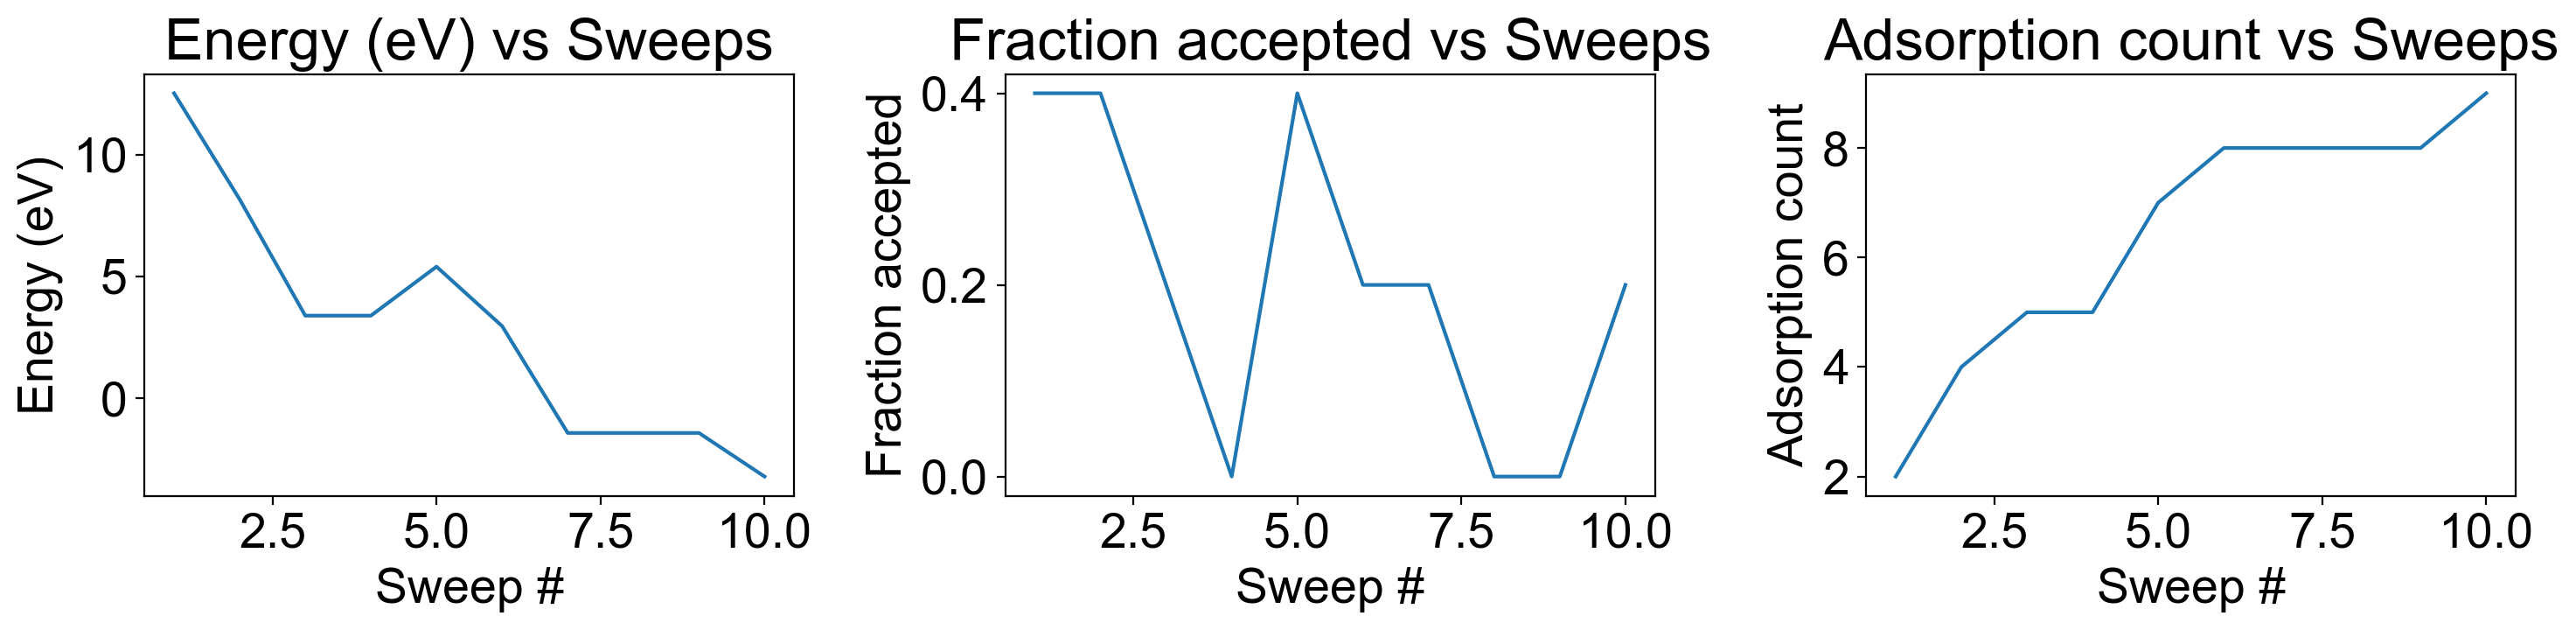

In [11]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [13]:
structures = results["history"]
with open("data/SrTiO3_001/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)